In [ ]:
# default_exp gbe

# GBE

> This submodule handles the analysis of GBE data.  It is build around GBEProvider which is inherited (copies all functions) from `DataProvider`.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [ ]:
#export
import numpy as np
from trr265.data_provider import DataProvider, get_efficiently
from fastcore.foundation import patch
import pandas as pd
from matplotlib import pyplot as plt
import re

In [ ]:
#export
class GBEProvider(DataProvider):
    '''This class builds upon DataProvider and focusses on GBE data.'''
    def __init__(self, data_folder_path):
        DataProvider.__init__(self, data_folder_path)
        self.GBE_COLUMNS = ['FruitTapGame','WorkingMemoryGame','CardGame','RewardAndHappinessGame']

In [ ]:
dp = GBEProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')

## Getting GBE Data

> We first select GBE data from movisense.

In [ ]:
#export 
@patch
def get_gbe_from_movisense(self:GBEProvider):
    """
    This function pulls GBE data from movisense and sets cancelled sessions to None.  Here, we only include rows that have at least one non-cancelled GBE game.
    """
    # Getting GBE data
    df = self.get_mov_data().query("Form == 'GreatBrainExperiment'")
    # Setting cancelled sessions to missing
    df[self.GBE_COLUMNS] = df[self.GBE_COLUMNS].replace({'{canceled": true}"':None})
    # Only included rows with at least one non-cancelled GBE game
    df = df[~df[self.GBE_COLUMNS].isna().all(axis=1)]
    df = df.sort_values(['participant','trigger_date'])
    shifted = df.groupby('participant').sampling_day.shift(1)
    df['time_since_last_gbe'] = df['sampling_day'] - shifted
    df['time_since_last_gbe'].fillna(0, inplace = True)
    df['session_number'] = df.groupby('participant').cumcount() + 1
    # Creating the trigger type variable
    replace_dict = {
    'Button Pressed Spiele starten und Initialfragen (~40min)':'initial',
    'Participant Defined Time Trigger':'ema',
    'Button Pressed Bedarfstart GBE (Ausnahme)':'optional',
    'Button Pressed Bedarfsstart GBE':'optional'}
    df['trigger_type'] = df.Trigger.apply(lambda x: x.replace('Pressed:','Pressed').split(':')[0]).replace(replace_dict)
    df['gbe_index'] = df.participant + '_' + df.session_number.apply(lambda x: '%03d'%int(x))
    df = df.set_index('gbe_index')
    return df

## Defining the initial dataset
> We sort the data by starting date and first trigger date (in case participants have same starting date).  Based on this sorted dataset, we select the first 300 participants.

In [ ]:
#export
@patch
def define_initial_dataset(self:GBEProvider, df):
    initial_pps = df.sort_values(['starting_date','trigger_date']).groupby('participant').first().iloc[:300].index
    df['is_initial'] = df.participant.isin(initial_pps)
    df = df.sort_index()
    return df

In [ ]:
df.groupby('participant')[['is_initial','starting_date','trigger_date']].first()

,is_initial,starting_date,trigger_date
participant,,,
b001,True,2020-02-24,2020-02-24 20:33:02
b002,True,2020-03-09,2020-03-09 11:39:06
b012,True,2020-06-28,2020-06-28 21:02:07
b013,True,2020-06-28,2020-07-07 18:27:42
b015,True,2020-06-21,2020-06-29 18:31:58
...,...,...,...
m231,False,2021-08-09,2021-08-09 09:00:50
m232,False,2021-08-16,2021-08-16 09:15:44
m235,False,2021-05-17,2021-05-17 21:13:15


## Defining the baseline sessions
Baseline sessions are the participants first two sessions if completed on the same day.  Otherwise the participants first session if it was not triggered by an EMA trigger.

In [ ]:
#export
@patch
def define_baseline_sessions(self:GBEProvider, df):
    first_two_sessions = df.session_number <= 2
    same_day = df.time_since_last_gbe == 0
    initial_or_optional = df.trigger_type != 'ema'
    df['is_baseline'] = first_two_sessions & same_day & initial_or_optional
    return df

In [ ]:
dp.define_baseline_sessions(df)[['participant','session_number','trigger_type','time_since_last_gbe','is_baseline']]

,participant,session_number,trigger_type,time_since_last_gbe,is_baseline
gbe_index,,,,,
b001_001,b001,1,initial,0.0,True
b001_002,b001,2,initial,0.0,True
b001_003,b001,3,ema,22.0,False
b001_004,b001,4,ema,118.0,False
b001_005,b001,5,ema,63.0,False
...,...,...,...,...,...
m271_006,m271,6,ema,28.0,False
m271_007,m271,7,ema,28.0,False
m271_008,m271,8,ema,28.0,False


### Checks

#### Number of baseline sessions per participant

In [ ]:
check = df.groupby('participant').is_baseline.sum().value_counts().to_frame()
check.columns = ['Participants']
check.index.rename('Baseline sessions', inplace = True)
check

,Participants
Baseline sessions,
2,305
1,51
0,9


> Most participants have two baseline sessions.  However, some only have one and a few participants have no baseline session.

#### Time between baseline sessions

In [ ]:
#export 
@patch
def find_gbe_game_starting_time(self:GBEProvider, s):
    '''As baseline GBEs have the same trigger date, we first have to parse the time from the GBE data.'''
    nan_time = pd.to_datetime(np.nan)
    try:
        gbe_columns = s.split(',')
    
    except:
        return nan_time
    if 'timestarted' not in gbe_columns:
        return nan_time
    time_started_index = gbe_columns.index('timestarted')
    time_started = pd.to_datetime(s.split('\n')[1].split(',')[time_started_index][2:-2])
    return time_started



@patch
def check_time_between_sessions(self:GBEProvider, df): 
    time_1 = pd.to_datetime(np.nan)
    time_2 = pd.to_datetime(np.nan)
    if len(df)==2:
        time_1 = self.find_gbe_game_starting_time(df.iloc[0])
        time_2 = self.find_gbe_game_starting_time(df.iloc[1])
    try:
        return (time_2 - time_1).seconds/60
    except:
        return np.nan

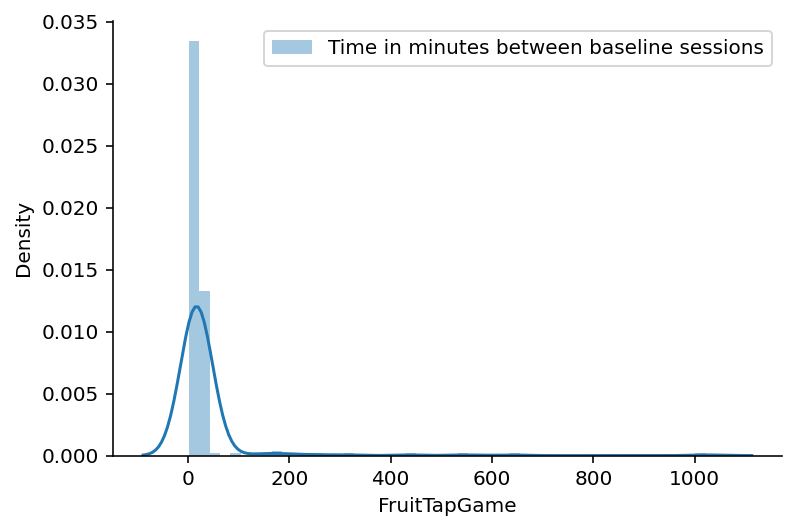

In [ ]:
time_between_sessions = df.query('is_baseline').groupby('participant').FruitTapGame.agg(dp.check_time_between_sessions)
sns.distplot(time_between_sessions, label = "Time in minutes between baseline sessions")
plt.legend()
sns.despine()

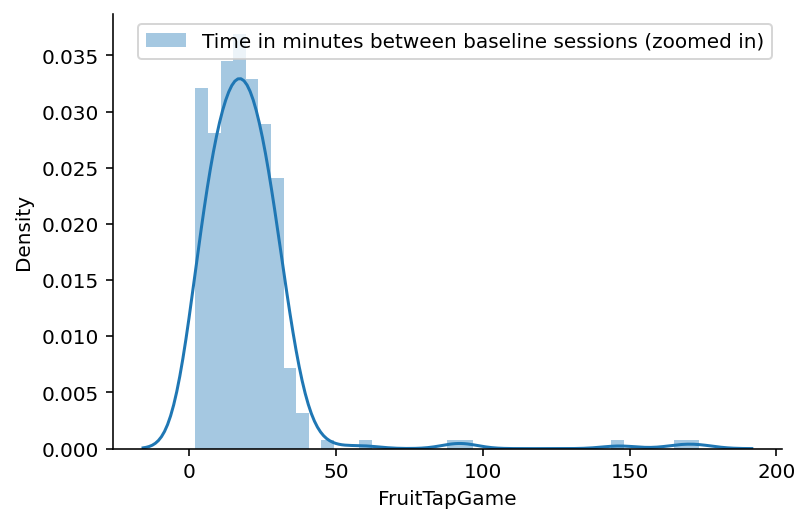

In [ ]:
sns.distplot(time_between_sessions[time_between_sessions < 200], label = "Time in minutes between baseline sessions (zoomed in)")
plt.legend()
sns.despine()

> Most participants took under one hour between baseline sessions.  Note that there is some variance, so we could check whether reliability already decreases within minutes.

#### Time between EMA sessions

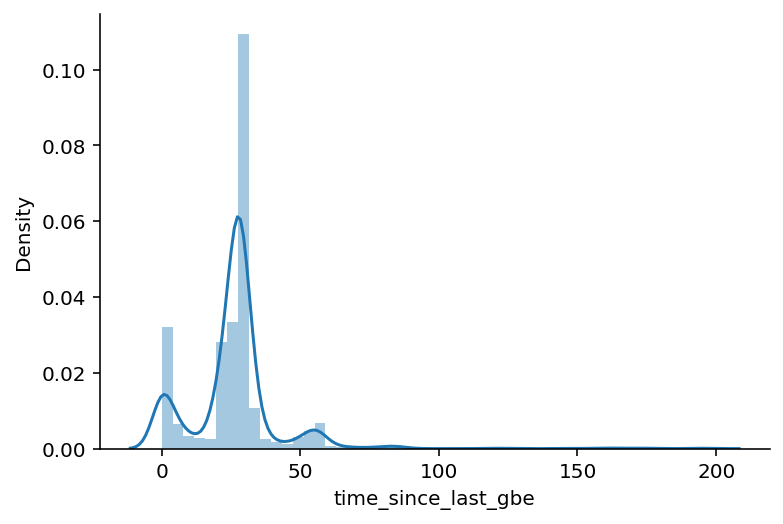

In [ ]:
sns.distplot(df.query("is_baseline==False").time_since_last_gbe, label = "Time in minutes between ema sessions")
sns.despine()

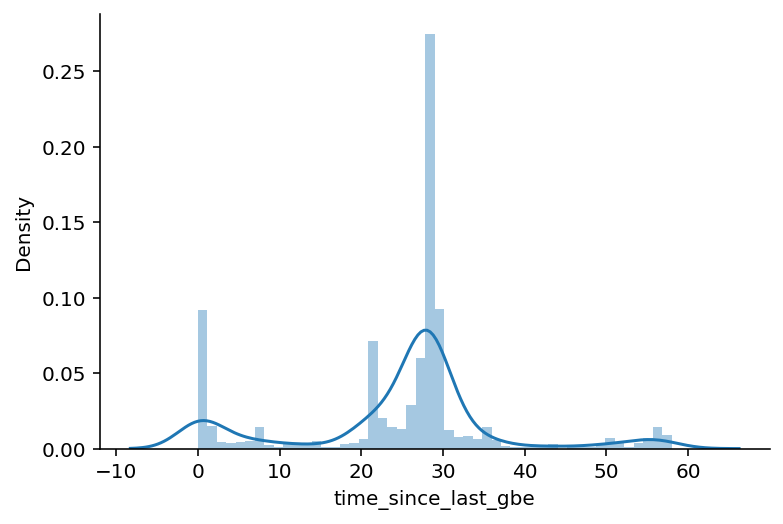

In [ ]:
sns.distplot(df.query("(is_baseline==False) and (time_since_last_gbe < 60)").time_since_last_gbe, label = "Time in minutes between ema sessions")
sns.despine()

> Most ema sessions are completed after 28 days (as expected).  However, some ema sessions seem to have been completed right after the baseline sessions.  Perhaps these sessions should be removed from the data.

> Warning: Some ema sessions are completed right after the baseline sessions.

## Getting the final data

In [ ]:
#export
@patch
def get_gbe_data(self:GBEProvider):
    df = self.get_gbe_from_movisense()
    df = self.define_initial_dataset(df)
    df = self.define_baseline_sessions(df)
    return df

@patch
def get_initial_baseline(self:GBEProvider):
    df = self.get_gbe_data()
    return df.query("is_initial and is_baseline")

@patch
def get_replication_baseline(self:GBEProvider):
    df = self.get_gbe_data()
    return df.query("(is_baseline and (not initial)")

## Decoding GBE strings
GBE data gets stored in strings, which will have to be decoded before they are useable for later analyses:

In [ ]:
df.FruitTapGame.iloc[0]

'appversion,score,timestarted,timesubmitted,tr_anticipation,tr_gobaddelay,tr_informed,tr_lefttime,tr_righttime,tr_stop,tr_success,\nMovisensXS-12","346","[2020-02-24 20:33:59.984]","[2020-02-24 20:36:11.123]","2015,2505,2154,1175,2630,2093,1644,2707,2090,1723,2951,2968,2060,1443,2984,1825,2366,2160,2673,2265,1843,1925,2287,1976,2015,1133,1572,1533,2192,1714,1977,2074,","0,0,0,350,300,0,350,400,0,350,0,0,300,0,0,0,0,0,250,0,0,0,0,200,0,0,250,0,0,300,250,300,","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,","0,769,635,0,619,0,0,0,669,0,719,0,0,0,667,0,653,684,0,902,568,614,634,652,619,0,636,736,668,0,635,0,","0,0,0,0,0,620,652,0,0,0,0,0,0,767,0,668,0,0,0,0,0,0,0,0,0,683,0,0,0,0,0,0,","0,0,0,2,2,0,1,2,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,2,0,0,1,2,1,","0,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,0,1,","'

In [ ]:
#export 
@patch
def decode_gbe_string(self:GBEProvider, s):
    """This function function turns one gbe output string into a dataframe"""
    def replace(g):
        return g.group(0).replace(',', '|')
    s = re.sub(r'\[.*?\]', replace, s) # The comma separated string can contain comma separated list items
    columns, df = s.replace('","',';').replace('"','').split('\n')
    df = pd.DataFrame([column.split(',') for column in df.split(';')][:-1]).transpose().ffill().iloc[:-1]
    df.columns = [c.replace('tr_','') for c in columns.split(',')[:-1]]
    def to_datetime(x):
        return pd.to_datetime(x[1:-1])
    if 'timestarted' in df.columns:
        df['timestarted'] = df.timestarted.apply(to_datetime)
        df['timesubmitted'] = df.timesubmitted.apply(to_datetime)
        df.drop(columns = 'appversion', inplace = True)
    else:
        df['timestarted'] = pd.to_datetime(np.nan)
        df['timesubmitted'] = pd.to_datetime(np.nan)
    return df

### Decoded data examples
Here are some examples of some decoded data strings.  We will further process this data in the specific task notebooks.

#### SSRT

In [ ]:
dp.decode_gbe_string(df.FruitTapGame.iloc[0])

,score,timestarted,timesubmitted,anticipation,gobaddelay,informed,lefttime,righttime,stop,success
0,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,2015,0,0,0,0,0,0
1,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,2505,0,0,769,0,0,1
2,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,2154,0,0,635,0,0,1
3,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,1175,350,0,0,0,2,1
4,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,2630,300,0,619,0,2,0
5,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,2093,0,0,0,620,0,1
6,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,1644,350,0,0,652,1,0
7,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,2707,400,0,0,0,2,1
8,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,2090,0,0,669,0,0,1
9,346,2020-02-24 20:33:59.984,2020-02-24 20:36:11.123,1723,350,0,0,0,1,1


#### Working memory game

In [ ]:
dp.decode_gbe_string(df.WorkingMemoryGame.iloc[0])

,score,timestarted,timesubmitted,success,timetaken,trialid,trialrot
0,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.506,420,1
1,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.471,379,1
2,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.154,343,1
3,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,2.004,463,0
4,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.589,616,3
5,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.856,746,0
6,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.623,780,1
7,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.571,698,2
8,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,2.139,1068,0
9,600,2020-02-24 20:48:52.812,2020-02-24 20:52:50.167,1,1.556,927,2


#### Card game

In [ ]:
dp.decode_gbe_string(df.CardGame.iloc[0])

,score,timestarted,timesubmitted,cardlist,decisiontime,guesstime,movelist,secondcard,success,trialtype,turntime
0,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[4|18|22|5],0.70,1.09,[0|1],1,1,0,[1.54|1.34]
1,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[40|32|26|31],0.64,2.56,[2|0],0,1,0,[1.20|0.89]
2,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[38|1|26|9],0.54,1.30,[1|2|3],2,1,0,[42.03|1.04|0.71]
3,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[34|27|12|33],0.69,0.55,[3|1|0],1,0,0,[1.54|0.67|0.50]
4,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[19|35|25|17],2.51,1.37,[0],1,1,0,[1.14]
5,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[19|14|34|1],0.65,0.99,[3|2],2,1,0,[0.99|0.69]
6,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[34|8|35|24],0.64,0.10,[0|3|2],3,1,0,[1.12|0.65|0.45]
7,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[9|7|36|12],0.67,0.15,[1|0],0,1,0,[0.95|0.75]
8,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[15|9|32|20],0.40,0.55,[3|1],1,1,0,[1.05|0.85]
9,990,2020-02-24 20:36:21.597,2020-02-24 20:45:10.161,[27|36|20|31],0.60,0.13,[3|2],2,1,0,[0.94|0.62]


#### Gambling task

In [ ]:
dp.decode_gbe_string(df.RewardAndHappinessGame.iloc[0])

,score,timestarted,timesubmitted,choiceamount,decisiontime,happiness,happinessstart,happinesstime,spinnerangle,spinnerloseamount,spinnerwinamount,spintime,trialresult
0,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,35,4.993,0.780,0.680,4.586,5.658,0,79,3.744,1
1,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,-45,2.204,-1.000,-1.000,-1.000,0.000,-95,0,-0.000,3
2,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,0,3.009,0.840,0.610,4.079,0.000,-150,75,-0.000,3
3,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,35,2.755,-1.000,-1.000,-1.000,0.000,0,70,-0.000,3
4,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,45,2.074,-1.000,-1.000,-1.000,1.456,0,93,5.496,2
5,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,0,3.175,0.840,0.580,2.241,3.774,-11,55,4.528,1
6,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,-55,2.604,-1.000,-1.000,-1.000,0.000,-120,0,-0.000,3
7,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,35,1.958,-1.000,-1.000,-1.000,0.643,0,68,4.492,2
8,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,0,2.690,0.840,0.390,2.340,0.000,-80,40,-0.000,3
9,473,2020-02-24 20:45:26.418,2020-02-24 20:48:40.195,55,3.492,-1.000,-1.000,-1.000,0.000,0,124,-0.000,3


### Decoding all sessions at once

In [ ]:
#export
@patch
def decode_gbe_strings(self:GBEProvider, df, column):
    '''This function turns all gbe output strings in a column into dataframes and concatenates them.'''
    df = df[~df[column].isna()] # Selecting non nan data
    #gbe_data = pd.concat(df.set_index(['participant','session_number'])[column].apply(self.decode_gbe_string).values, keys = df.index)
    #gbe_data = pd.concat(df[column].apply(self.decode_gbe_string).values)
    df = pd.concat(df[column].apply(self.decode_gbe_string).values, keys = df.index)
    df.index.rename('trial_number',level = 1, inplace = True)
    df = df.reset_index()
    df['trial_number'] = df.trial_number + 1
    return df

We double check that the decoding worked by testing it against our earlier defined `find_gbe_game_starting_time` function.

In [ ]:
def test_decoding(df, decoded):
    df = df[~df.FruitTapGame.isna()]
    decoded = decoded.groupby('gbe_index').first()
    for loc in range(len(decoded)):
        time_started_1 = dp.find_gbe_game_starting_time(df.iloc[loc].FruitTapGame)
        time_started_2 = decoded.iloc[loc]['timestarted']
        both_nan = (pd.isnull(time_started_1)) and (pd.isnull(time_started_1))
        equal = time_started_1 == time_started_2
        assert equal or both_nan, "Decoding problem at %d %s != %s"%(loc, str(time_started_1), str(time_started_2))
    print("Check passed.")
    
test_decoding(df, decoded)

Check passed.
